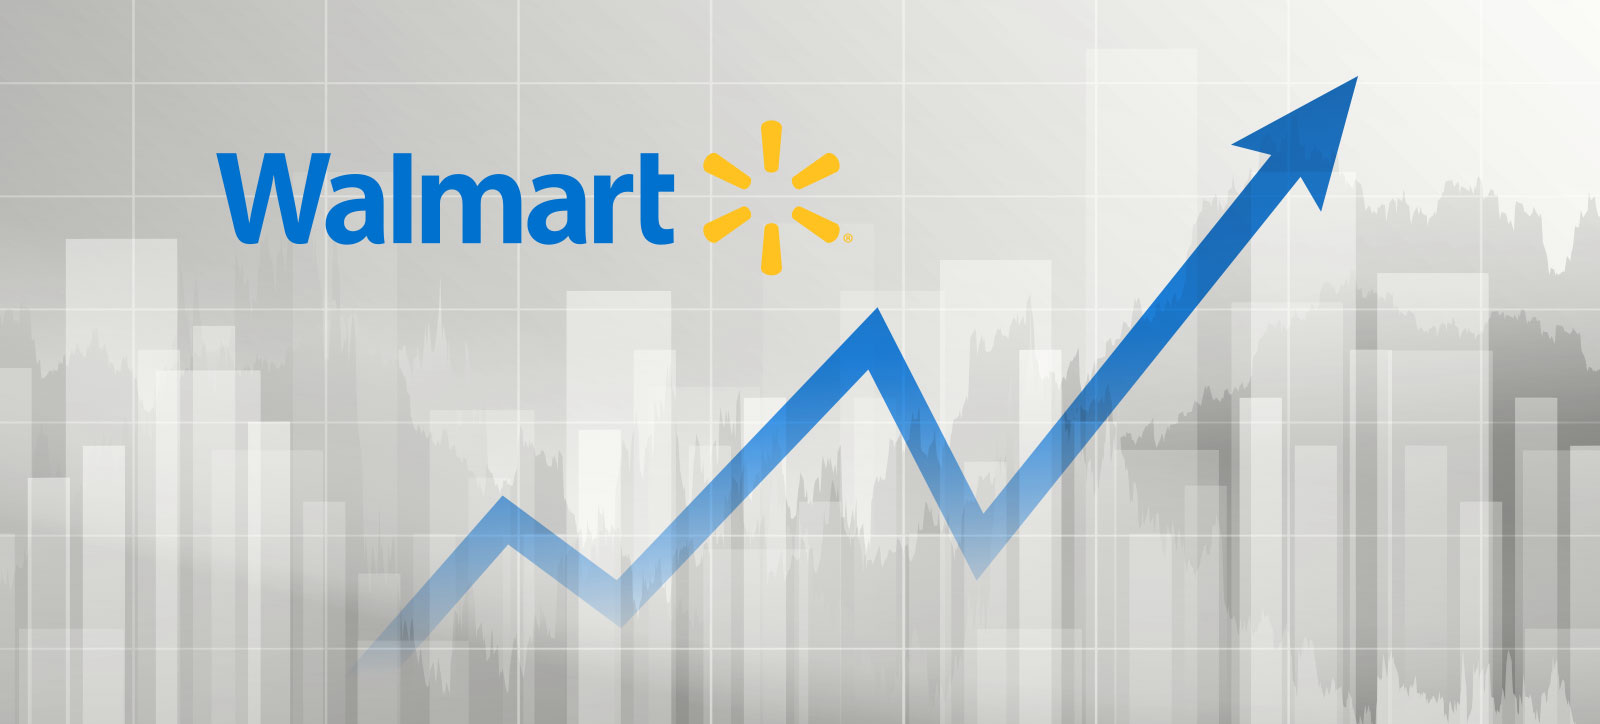

## About the Data

Datasets: [Walmart - Store Sales Forecasting](https://www.kaggle.com/code/avelinocaio/walmart-store-sales-forecasting/data)

We are provided with historical sales data for 45 Walmart stores located in different regions. Each store contains a number of departments, and you are tasked with predicting the department-wide sales for each store.

In addition, Walmart runs several promotional markdown events throughout the year. These markdowns precede prominent holidays, the four largest of which are the Super Bowl, Labor Day, Thanksgiving, and Christmas. The weeks including these holidays are weighted five times higher in the evaluation than non-holiday weeks. Part of the challenge presented by this competition is modeling the effects of markdowns on these holiday weeks in the absence of complete/ideal historical data.

**stores.csv**: This dataset contains anonymized information for 45 stores, specifying the type and size of each






**train.csv**: this is the historical training data, which covers to 2010-02-05 to 2012-11-01. include:

1.   Store - the store number
2.   Dept - the department number
3. Date - the week
4. Weekly_Sales -  sales for the given department in the given store
5. IsHoliday - whether the week is a special holiday week



**test.csv**: This file is identical to train.csv, except we have withheld the weekly sales. We should predict the sales for each triplet of store, department, and date in this file.

**features.csv**: This file contains additional data related to the store, department, and regional activity for the given dates. It contains the following fields:


1.   Store - the store number
2. Date - the week
3. Temperature - average temperature in the region
4. Fuel_Price - cost of fuel in the region
5. MarkDown1-5 - anonymized data related to promotional markdowns that Walmart is running. MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA.
6. CPI - the consumer price index
7. Unemployment - the unemployment rate
8. IsHoliday - whether the week is a special holiday week



For convenience, the four holidays fall within the following weeks in the dataset (not all holidays are in the data):

    
Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13

Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13

Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13

Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import iplot

from sklearn.model_selection import train_test_split
from math import sqrt
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import warnings

## Read the data

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
stores_df = pd.read_csv('stores.csv')
features_df = pd.read_csv('features.csv')

## Data Understanding

In [3]:
train_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [4]:
train_df.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday'], dtype='object')

In [5]:
train_df.shape

(421570, 5)

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [7]:
train_df.describe()

,Store,Dept,Weekly_Sales
count,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123
std,12.785297,30.492054,22711.183519
min,1.000000,1.000000,-4988.940000
25%,11.000000,18.000000,2079.650000
50%,22.000000,37.000000,7612.030000
75%,33.000000,74.000000,20205.852500
max,45.000000,99.000000,693099.360000


In [8]:
train_df.isnull().sum()

,0
Store,0
Dept,0
Date,0
Weekly_Sales,0
IsHoliday,0


In [9]:
features_df.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [10]:
features_df.columns

Index(['Store', 'Date', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
       'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment',
       'IsHoliday'],
      dtype='object')

In [11]:
features_df.shape

(8190, 12)

In [12]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


In [13]:
features_df.describe()

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,8190.000000,8190.000000,8190.000000,4032.000000,2921.000000,3613.000000,3464.000000,4050.000000,7605.000000,7605.000000
mean,23.000000,59.356198,3.405992,7032.371786,3384.176594,1760.100180,3292.935886,4132.216422,172.460809,7.826821
std,12.987966,18.678607,0.431337,9262.747448,8793.583016,11276.462208,6792.329861,13086.690278,39.738346,1.877259
min,1.000000,-7.290000,2.472000,-2781.450000,-265.760000,-179.260000,0.220000,-185.170000,126.064000,3.684000
25%,12.000000,45.902500,3.041000,1577.532500,68.880000,6.600000,304.687500,1440.827500,132.364839,6.634000
50%,23.000000,60.710000,3.513000,4743.580000,364.570000,36.260000,1176.425000,2727.135000,182.764003,7.806000
75%,34.000000,73.880000,3.743000,8923.310000,2153.350000,163.150000,3310.007500,4832.555000,213.932412,8.567000
max,45.000000,101.950000,4.468000,103184.980000,104519.540000,149483.310000,67474.850000,771448.100000,228.976456,14.313000


In [14]:
features_df.isnull().sum()

,0
Store,0
Date,0
Temperature,0
Fuel_Price,0
MarkDown1,4158
MarkDown2,5269
MarkDown3,4577
MarkDown4,4726
MarkDown5,4140
CPI,585


This dataframe has lots of null values

In [15]:
stores_df.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [16]:
stores_df.columns

Index(['Store', 'Type', 'Size'], dtype='object')

In [17]:
stores_df.shape

(45, 3)

In [18]:
stores_df. info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


In [19]:
stores_df.describe()

,Store,Size
count,45.000000,45.000000
mean,23.000000,130287.600000
std,13.133926,63825.271991
min,1.000000,34875.000000
25%,12.000000,70713.000000
50%,23.000000,126512.000000
75%,34.000000,202307.000000
max,45.000000,219622.000000


In [20]:
stores_df.isnull().sum()

,0
Store,0
Type,0
Size,0


Visualizing the Type of Stores along with their corresponding percentages

In [21]:
labels = stores_df['Type'].value_counts().index
values = stores_df['Type'].value_counts().values

color_palette = px.colors.qualitative.Set3
fig = go.Figure(data=[go.Pie(
    labels=labels,
    values=values,
    textinfo='label+percent',
    marker=dict(colors=color_palette)
)])

fig.show()

Type A holds the largest share of stores, making up 48.9% with 22 stores.

Since both features and stores share "Store" as a common column, we can merge the data

In [22]:
dataset = features_df.merge(stores_df, on='Store', how='inner')
dataset.head()


,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315


In [23]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
 12  Type          8190 non-null   object 
 13  Size          8190 non-null   int64  
dtypes: bool(1), float64(9), int64(2), object(2)
memory usage: 839.9+ KB


Visualizing the Type of Stores along with their corresponding percentages

In [24]:
labels = dataset['Type'].value_counts()[:10].index # Top10 index
values = dataset['Type'].value_counts()[:10].values #Top10 values

color_palette = px.colors.qualitative.Dark2
fig = go.Figure(data=[go.Pie(
    labels=labels,
    values=values,
    textinfo='label+percent',
    marker=dict(colors=color_palette)
)])

fig.show()

Visualizing the Top 10 Department in the train dataset along with their corresponding percentages

In [25]:
labels = train_df['Dept'].value_counts()[:10].index #  Top10 values
values = train_df['Dept'].value_counts()[:10].values # Top10 values

colors = train_df['Dept']
fig = go.Figure(data=[go.Pie(
    labels=labels,
    values=values,
    textinfo='label+percent',
    marker=dict(colors=colors)
)])

fig.show()

Visualizing the Top 10 Store in the train dataset along with their corresponding percentages

In [26]:
# Visualize the Store Data
labels = train_df['Store'].value_counts()[:10].index # Top10 index
values = train_df['Store'].value_counts()[:10].values #Top10 values

color_palette = px.colors.qualitative.Set3
fig = go.Figure(data=[go.Pie(
    labels=labels,
    values=values,
    textinfo='label+percent',
    marker=dict(colors=color_palette)
)])

fig.show()

Store number 13 has the highest proportion (10.2%)

Most stores have a fairly balanced distribution, with percentages ranging around 9.95% to 10%. This suggests that the data is not highly skewed towards any specific store.

Let's see how holidays are influenced by these stores

In [27]:
# Visualize the IsHoliday Data
labels = train_df['IsHoliday'].value_counts()[:10].index # Top10 index
values = train_df['IsHoliday'].value_counts()[:10].values #Top10 values

color_palette = px.colors.qualitative.Set3
fig = go.Figure(data=[go.Pie(
    labels=labels,
    values=values,
    textinfo='label+percent',
    marker=dict(colors=color_palette)
)])

fig.show()

93% of the time there is no Holiday

In [28]:
from datetime import datetime
dataset['Date'] = pd.to_datetime(dataset['Date'])
train_df['Date'] = pd.to_datetime(train_df['Date'])
test_df['Date'] = pd.to_datetime(test_df['Date'])

In [29]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int64(2)
memory usage: 13.3 MB


Create Week and Year columns

In [30]:
dataset['Week'] = dataset.Date.dt.isocalendar().week
dataset['Year'] = dataset.Date.dt.year

In [31]:
dataset.columns

Index(['Store', 'Date', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
       'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment',
       'IsHoliday', 'Type', 'Size', 'Week', 'Year'],
      dtype='object')

In [32]:
train_df.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday'], dtype='object')

In [33]:
# Merge the dataset with train_df
train_merge = train_df.merge(dataset, how='inner', on=['Store', 'Date', 'IsHoliday']).sort_values(by=['Store','Dept','Date']).reset_index(drop=True)

In [34]:
# Merge the dataset with train_df
test_merge = test_df.merge(dataset, how='inner', on=['Store', 'Date', 'IsHoliday']).sort_values(by=['Store','Dept','Date']).reset_index(drop=True)

In [35]:
def scatter(train_merge,column):
  plt.figure()
  plt.scatter(train_merge[column], train_merge['Weekly_Sales'], color='#B0D4F1')
  plt.xlabel(column)
  plt.ylabel('Weekly_Sales')

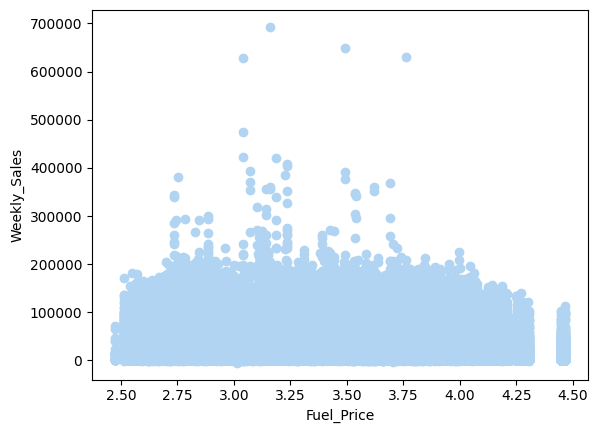

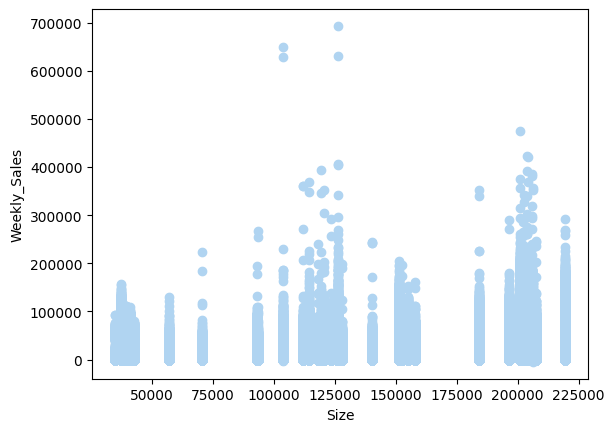

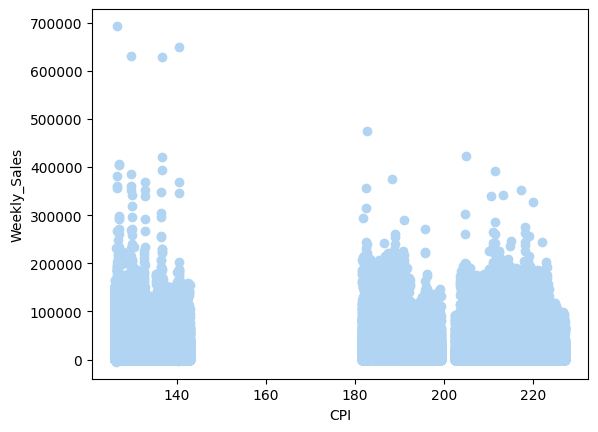

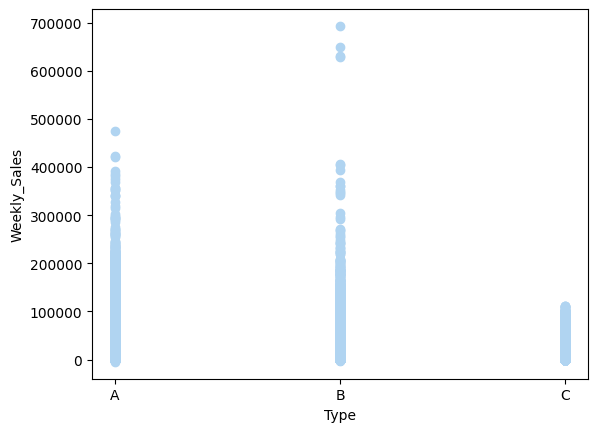

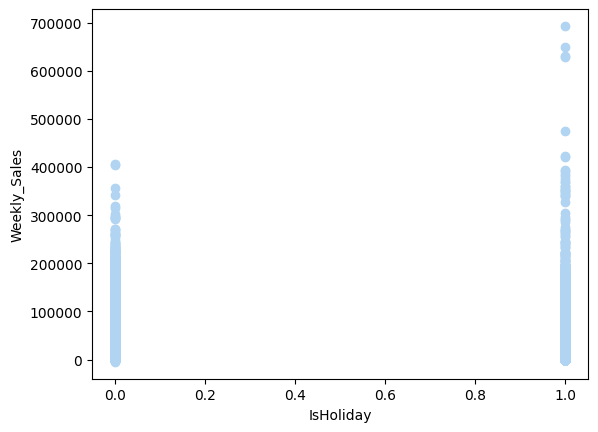

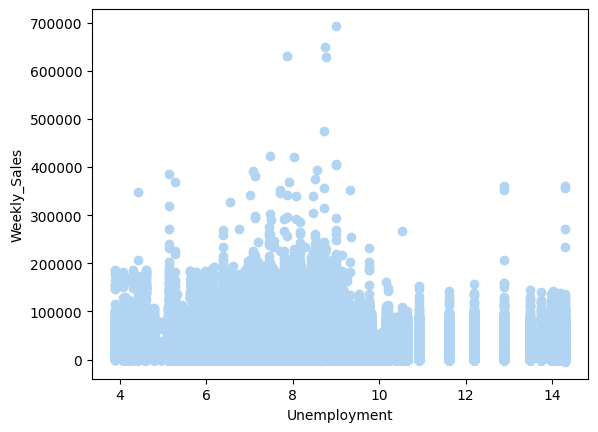

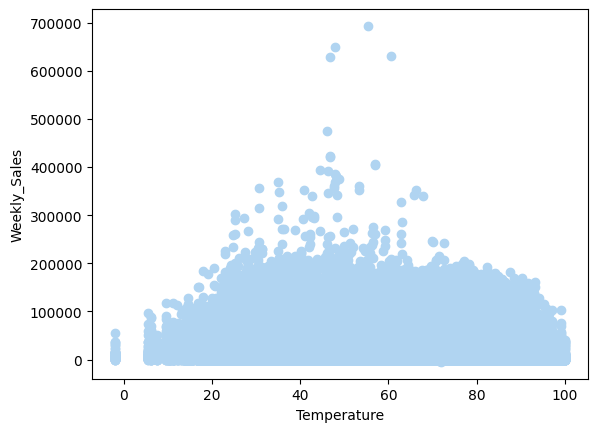

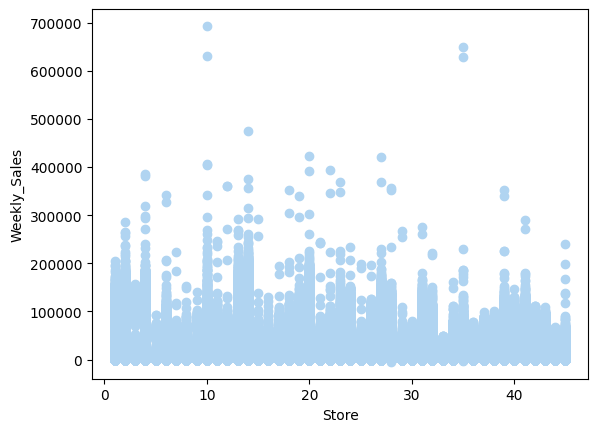

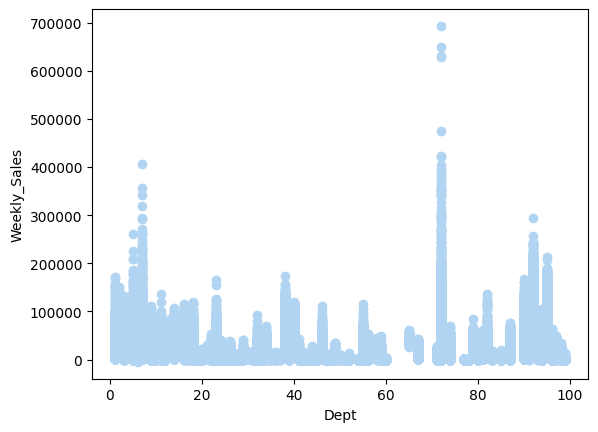

In [36]:
scatter(train_merge, 'Fuel_Price')
scatter(train_merge, 'Size')
scatter(train_merge, 'CPI')
scatter(train_merge, 'Type')
scatter(train_merge, 'IsHoliday')
scatter(train_merge, 'Unemployment')
scatter(train_merge, 'Temperature')
scatter(train_merge, 'Store')
scatter(train_merge, 'Dept')

The 'Weekly_Sales - Fuel Price' plot: \
As the fuel price grows, there is no obvious linear relationship between fuel prices and weekly sales. The points are scattered across all fuel price ranges. \
There are several outliers where weekly sales exceed 400,000, particularly when the fuel price is around 3.0 to 3.5. These could indicate promotional events, holidays, or special circumstances that boosted sales



The 'Weekly_Sales - Size' plot: \
Sales are higher in medium and large stores compared to smaller ones.

The 'Weekly_Sales - CPI(Consume Price Index)' plot: \
We observe that at lower CPI values (around 130-150), there is a higher concentration of sales, with a relatively large number of data points. This suggests that more sales activity occurs when CPI is lower, though there are also some notable high sales outliers in this range.

The 'Weekly_Sales - Type' plot: \
We have higher sales in Type A and *B*

The 'Weekly_Sales - Holiday' plot: \
Sales tend to increase during holiday events.

**Correlation Matrix**

Let's have a look at the Average Weekly Sales per Year and find out if there is any other holiday peak sales that were not considered by 'IsHoliday' field

<Axes: xlabel='Week'>

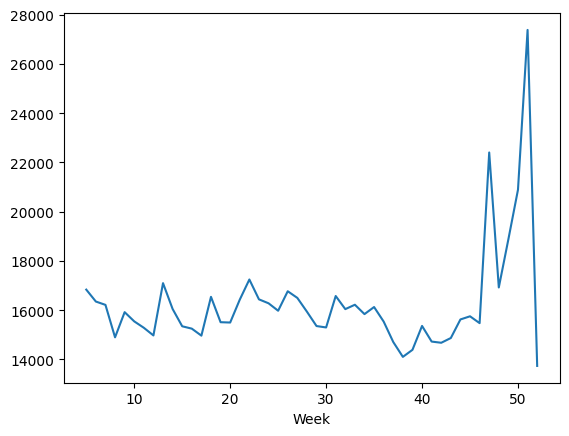

In [37]:
# Average weekly sales for the year 2010
weekly_sales_2010 = train_merge[train_merge['Year']==2010]['Weekly_Sales'].groupby(train_merge['Week']).mean()
sns.lineplot(x = weekly_sales_2010.index, y = weekly_sales_2010.values)

Toward the end of the year (after week 40), there are sharp increases in sales, with two significant spikes—one around week 45 and another near the end (week 50). This suggests possible holiday-season effects, such as Black Friday or Christmas shopping periods, where sales typically surge.

And after that, there is a sudden drop right after the peak, which could indicate the end of the holiday shopping period.

<Axes: xlabel='Week'>

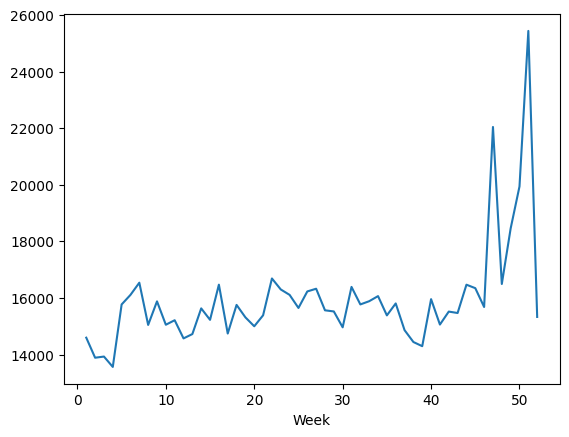

In [38]:
# Average weekly sales for the year 2011
weekly_sales_2011 = train_merge[train_merge['Year']==2011]['Weekly_Sales'].groupby(train_merge['Week']).mean()
sns.lineplot(x = weekly_sales_2011.index, y = weekly_sales_2011.values)

The spike in 2011 is slightly more gradual, starting around week 45, with a sharp peak around week 50, which is similar to 2010. However, the peak seems slightly less sharp in comparison to 2010, but still indicates a strong sales period.


<Axes: xlabel='Week'>

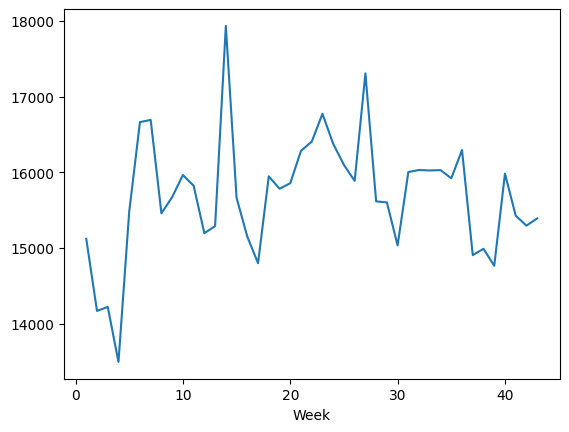

In [39]:
# Average weekly sales for the year 2012
weekly_sales_2012 = train_merge[train_merge['Year']==2012]['Weekly_Sales'].groupby(train_merge['Week']).mean()
sns.lineplot(x = weekly_sales_2012.index, y = weekly_sales_2012.values)

2012 does not show such a dramatic spike at the end of the year but maintains more consistent fluctuations throughout.

2012 has weekly sales fluctuating between 14,000 and 18,000 consistently, but lacks the extreme end-year spike seen in the previous years. The peaks in 2012 are more spread across the year rather than concentrated at the end.

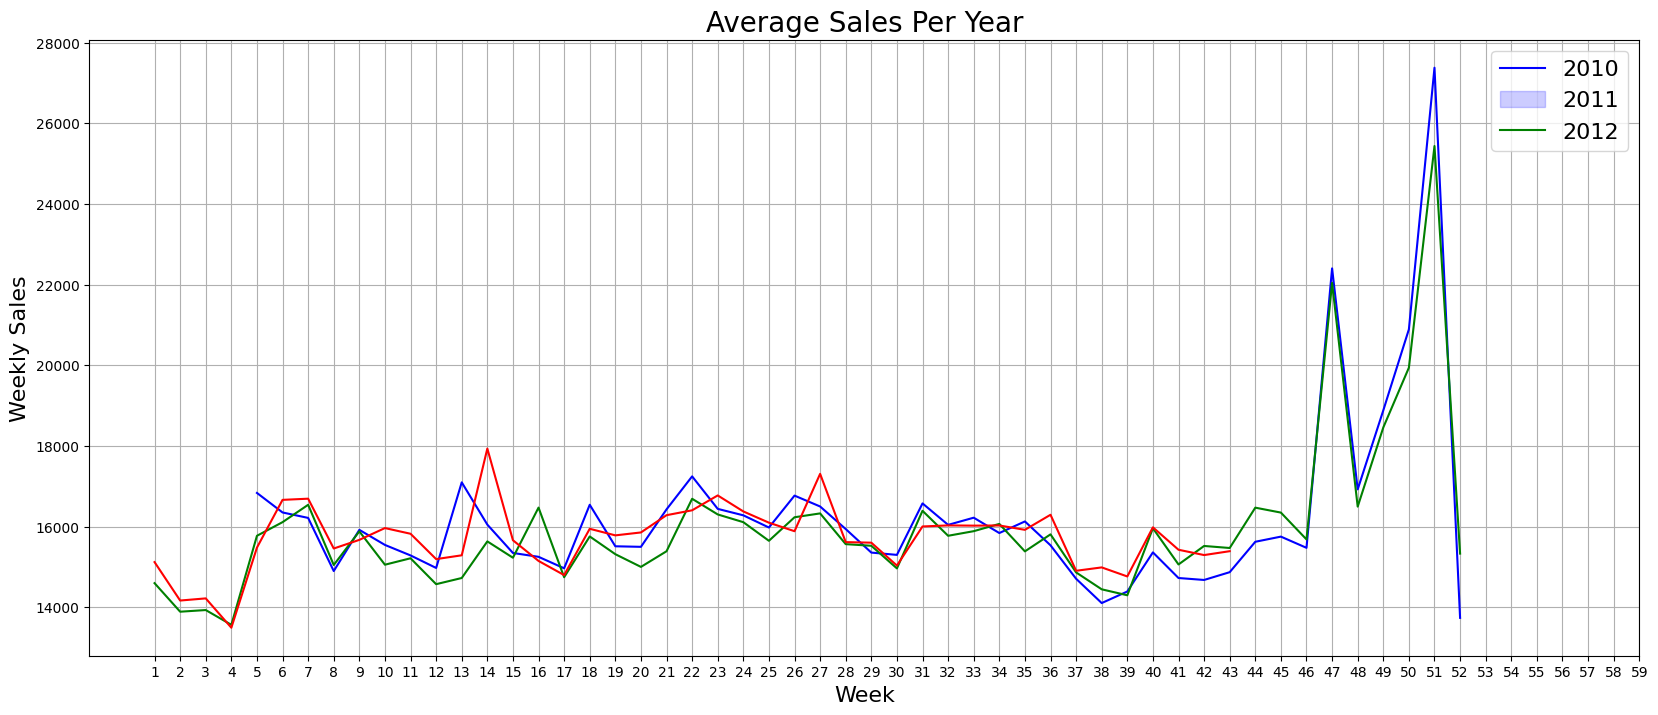

In [40]:
# Plot the 3 year graph together
plt.figure(figsize=(20,8))
sns.lineplot(x = weekly_sales_2010.index, y = weekly_sales_2010.values, color='blue', label='2010')
sns.lineplot(x = weekly_sales_2011.index, y = weekly_sales_2011.values, color='green', label='2011')
sns.lineplot(x = weekly_sales_2012.index, y = weekly_sales_2012.values, color='red', label='2012')
plt.grid()
plt.xticks(np.arange(1,60,step=1))
plt.legend(['2010','2011','2012'], loc='best', fontsize=16)
plt.title('Average Sales Per Year', fontsize=20)
plt.xlabel('Week', fontsize=16)
plt.ylabel('Weekly Sales', fontsize=16)
plt.show()

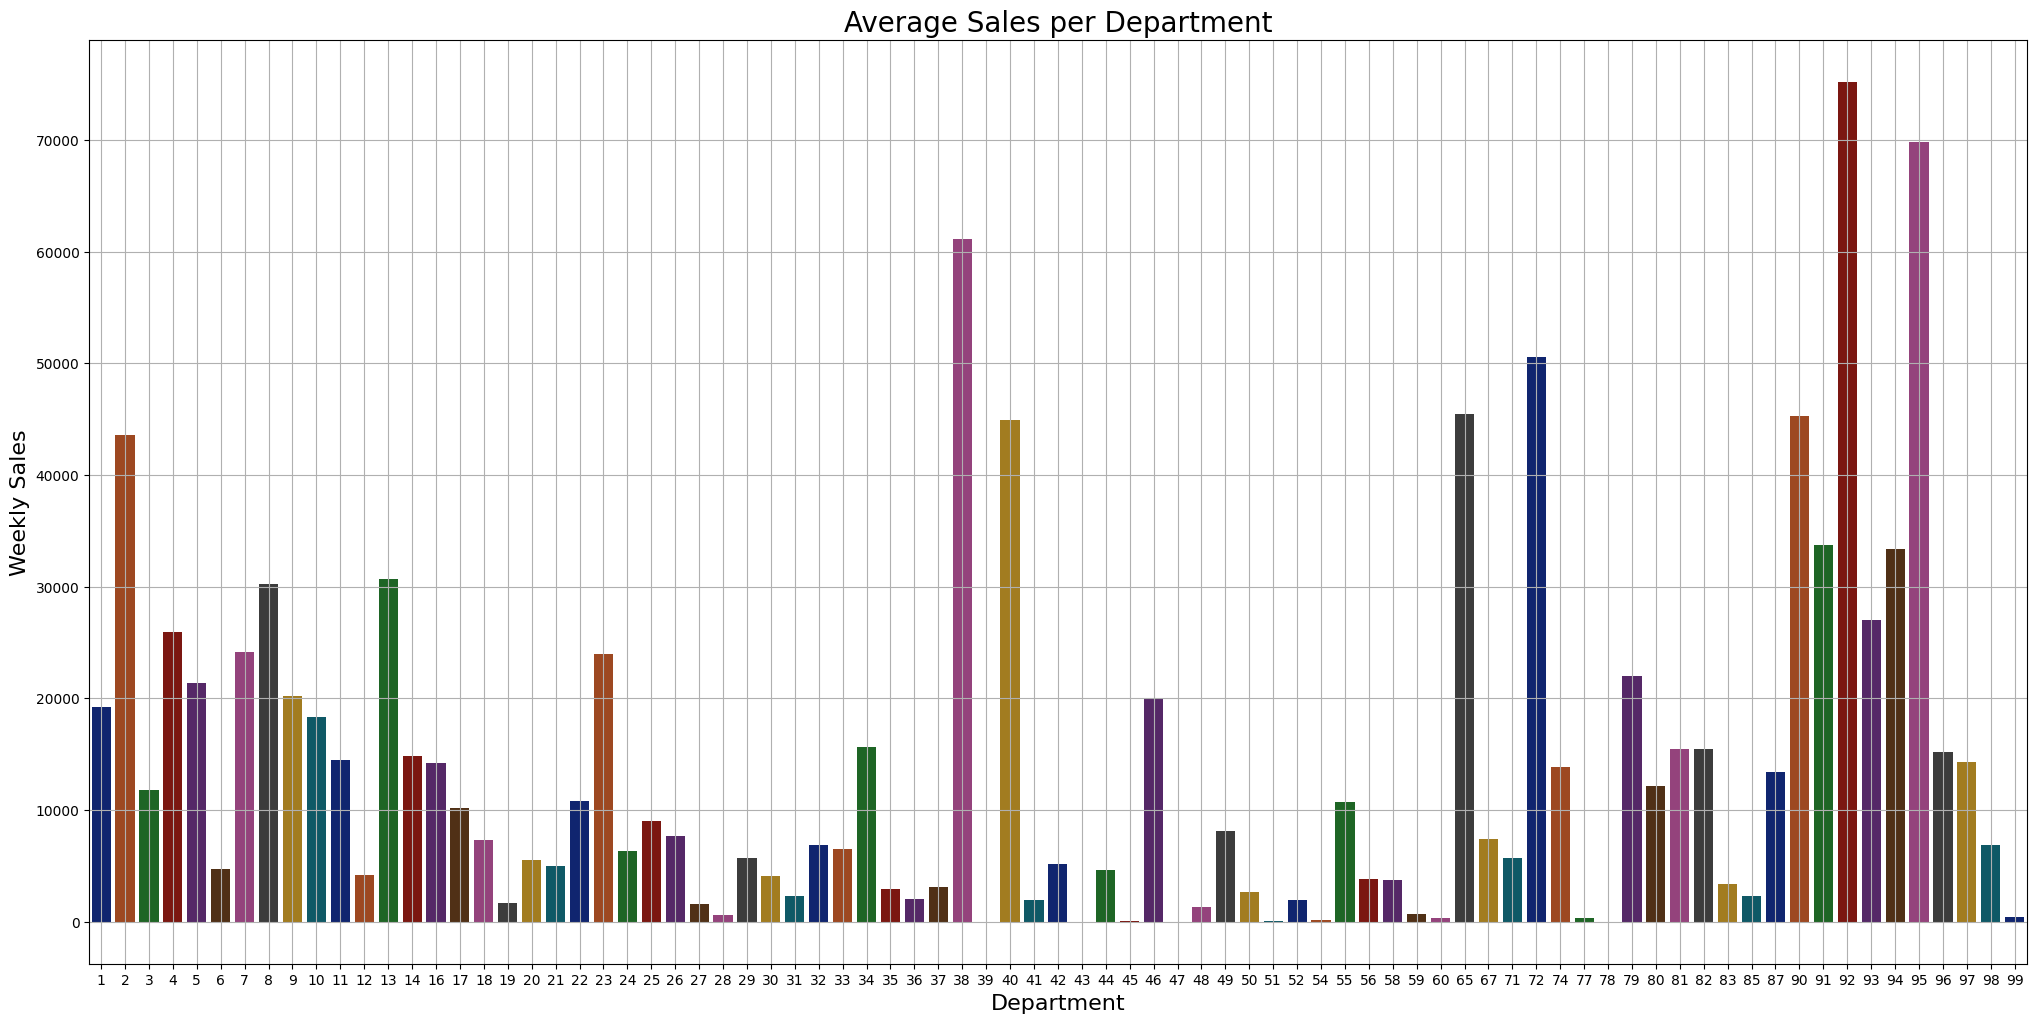

In [41]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Average Sales per Department
weekly_sales = train_merge['Weekly_Sales'].groupby(train_merge['Dept']).mean()
plt.figure(figsize=(25,12))
sns.barplot(x = weekly_sales.index, y = weekly_sales.values, palette ='dark')
plt.grid()
plt.title('Average Sales per Department', fontsize=20)
plt.xlabel('Department', fontsize=16)
plt.ylabel('Weekly Sales', fontsize=16)
plt.show()

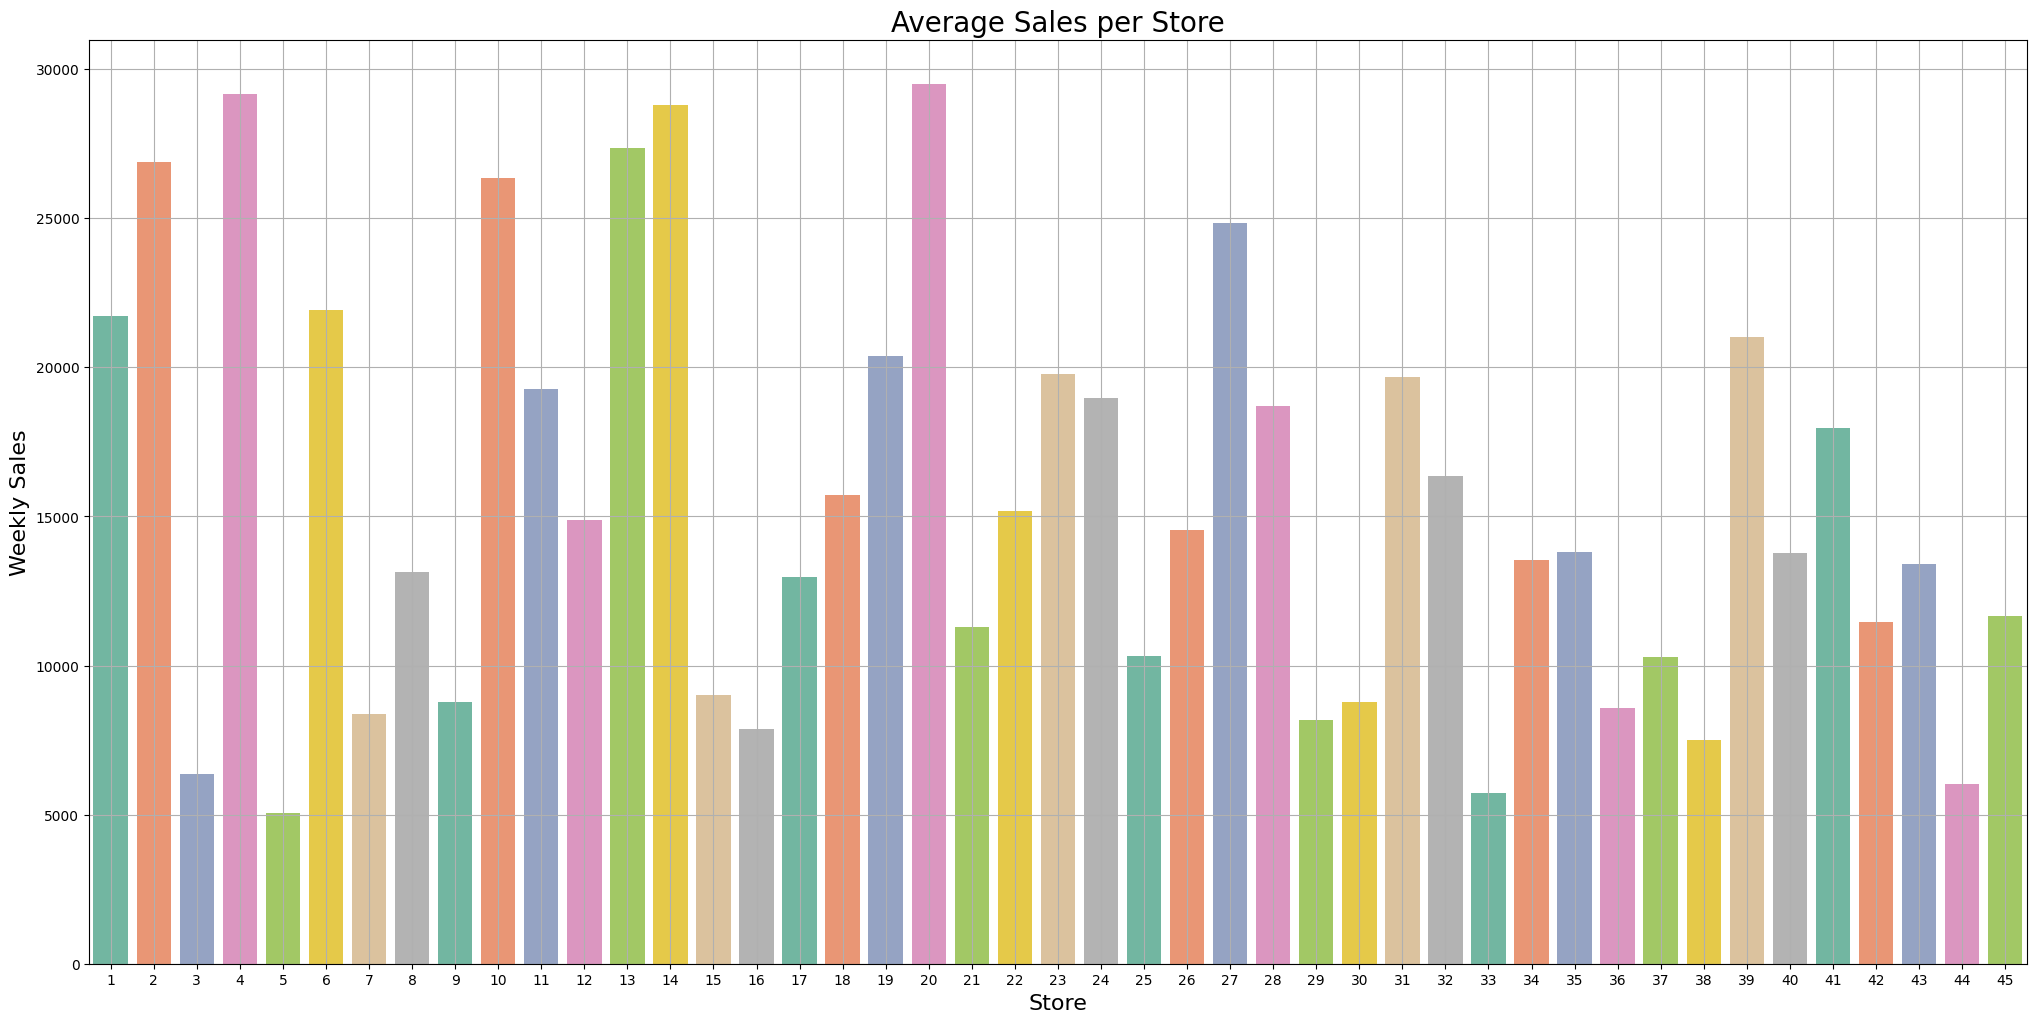

In [42]:
# Average Sales per Department
weekly_sales = train_merge['Weekly_Sales'].groupby(train_merge['Store']).mean()
plt.figure(figsize=(25,12))
sns.barplot(x = weekly_sales.index, y = weekly_sales.values, palette ='Set2')
plt.grid()
plt.title('Average Sales per Store', fontsize=20)
plt.xlabel('Store', fontsize=16)
plt.ylabel('Weekly Sales', fontsize=16)
plt.show()

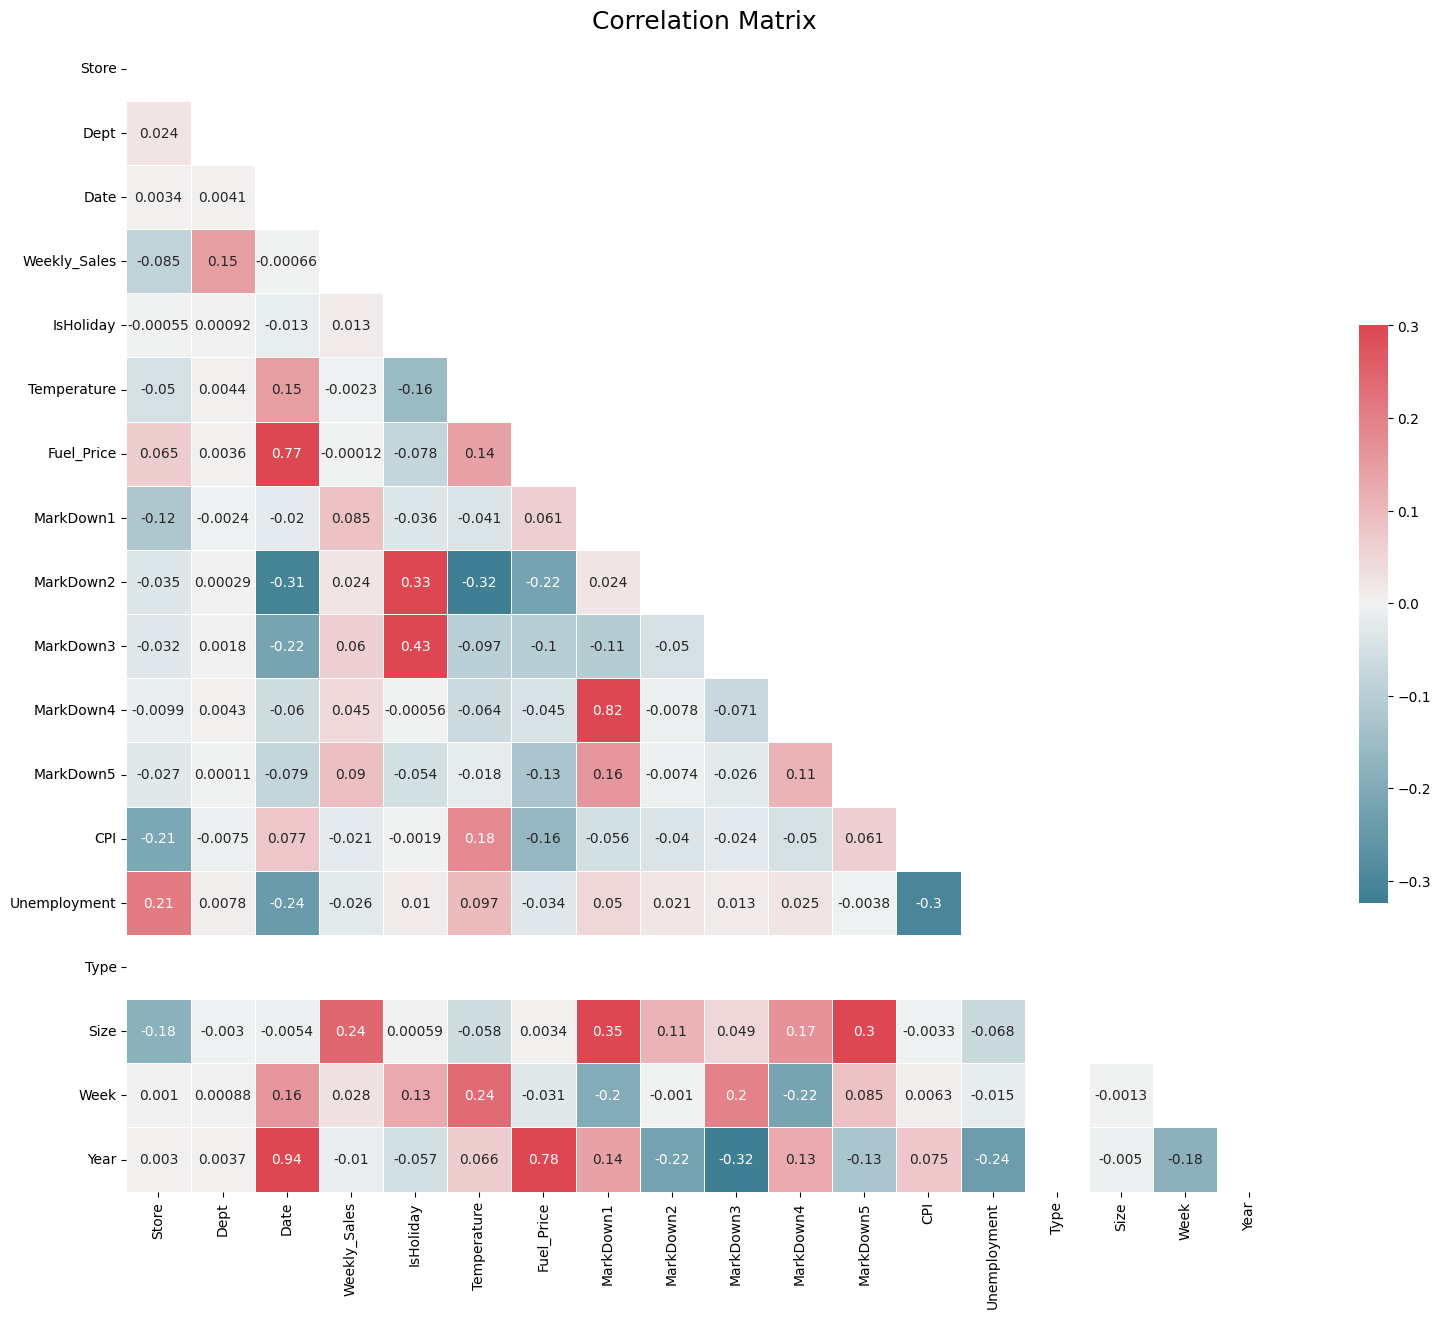

In [43]:
# Convert columns to numeric where possible
train_merge_numeric = train_merge.apply(pd.to_numeric, errors='coerce')

corr = train_merge_numeric.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(20, 15))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

plt.title('Correlation Matrix', fontsize=18)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()


In [44]:
# Dropping down the variables that have weak correlation

train_merge = train_merge.drop(columns=['Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'])
test_merge = test_merge.drop(columns=['Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'])

In [45]:
train_merge.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,CPI,Unemployment,Type,Size,Week,Year
0,1,1,2010-02-05,24924.50,False,42.31,211.096358,8.106,A,151315,5,2010
1,1,1,2010-02-12,46039.49,True,38.51,211.242170,8.106,A,151315,6,2010
2,1,1,2010-02-19,41595.55,False,39.93,211.289143,8.106,A,151315,7,2010
3,1,1,2010-02-26,19403.54,False,46.63,211.319643,8.106,A,151315,8,2010
4,1,1,2010-03-05,21827.90,False,46.50,211.350143,8.106,A,151315,9,2010


In [46]:
test_merge.head()

,Store,Dept,Date,IsHoliday,Temperature,CPI,Unemployment,Type,Size,Week,Year
0,1,1,2012-11-02,False,55.32,223.462779,6.573,A,151315,44,2012
1,1,1,2012-11-09,False,61.24,223.481307,6.573,A,151315,45,2012
2,1,1,2012-11-16,False,52.92,223.512911,6.573,A,151315,46,2012
3,1,1,2012-11-23,True,56.23,223.561947,6.573,A,151315,47,2012
4,1,1,2012-11-30,False,52.34,223.610984,6.573,A,151315,48,2012


In [47]:
# The number of unique values in Department
train_df['Dept'].nunique()

81

In [48]:
# The number of unique values in Store
train_df['Store'].nunique()

45

In [49]:
# The columns in train_merge
train_merge.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Temperature',
       'CPI', 'Unemployment', 'Type', 'Size', 'Week', 'Year'],
      dtype='object')

In [50]:
# The columns in test_merge
test_merge.columns

Index(['Store', 'Dept', 'Date', 'IsHoliday', 'Temperature', 'CPI',
       'Unemployment', 'Type', 'Size', 'Week', 'Year'],
      dtype='object')

### Divide the data into Train and Test


In [51]:
X = train_merge[['Store', 'Dept', 'IsHoliday', 'Size', 'Week', 'Year']]
y = train_merge['Weekly_Sales']

## Model Building

### Ridge Regression

In [52]:
# splitting the data into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Ridge regression is a linear regression model that includes an L2 regularization term. This regularization penalizes the magnitude of coefficients, helping to prevent overfitting, especially when there are correlated features or multicollinearity in the dataset. The strength of the regularization is controlled by the hyperparameter 'alpha'.

In Ridge Regression, **GridSearchCV** can be used to find the optimal value of the alpha parameter (the regularization strength) by testing a range of possible values and selecting the one that minimizes the validation error.

**step:**


1.   **Define the model:** Set up a Ridge Regression model.
2.   **Parameter grid:** Create a dictionary specifying the range of values for `alpha` to search over, such as `{ 'alpha': [0.1, 1, 10, 100] }`.

1.   **Cross-validation strategy:** Specify the number of folds for cross-validation (e.g., 5-fold cross-validation).
2.   **Fit and search:** GridSearchCV will fit the Ridge model for each value of `alpha`, evaluate it using cross-validation, and select the best performing `alpha`.





In [57]:
# Performing GridSearchCV on Ridge Regression
params = {'alpha' : [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}
ridge_regression = GridSearchCV(Ridge(), params, cv = 7, scoring='neg_mean_squared_error', n_jobs = -1)
ridge_regression.fit(X_train, y_train)

GridSearchCV(cv=7, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                                   10000, 100000]},
             scoring='neg_mean_squared_error')

In [58]:
# Predicting train and test resul
y_pred_train = ridge_regression.predict(X_train)
y_pred_test = ridge_regression.predict(X_test)

In [59]:
print('Train Result for Ridge Regression Model: ')
rmse = np.sqrt(mean_squared_error(y_train.values, y_pred_train))
print('Root Mean Squared Error: ', rmse)
print('R-Squared: ', r2_score(y_train.values, y_pred_train))

Train Result for Ridge Regression Model: 
Root Mean Squared Error:  21696.0905866754
R-Squared:  0.0844297334166948


The R² score is quite low (around 0.08), which means that the Ridge model is explaining only about 8% of the variance in the training data. The model might be underfitting.

In [67]:
print('Test Result for Ridge Regression Model: ')
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
print('Root Mean Squared Error: ', rmse)
print('R-Squared: ', r2_score(y_test, y_pred_test))

Test Result for Ridge Regression Model: 
Root Mean Squared Error:  21811.779181961523
R-Squared:  0.08454306433550207


The test results are quite similar to the training results, with a very close RMSE and R² score, which is also around 0.08. This indicates that the model is not overfitting, as the train and test performance are aligned, but both the train and test R² values are low.

### Decision Tree Regression

In [69]:
from sklearn.tree import DecisionTreeRegressor

depth = list(range(3,30))
param_grid = dict(max_depth = depth)
tree = GridSearchCV(DecisionTreeRegressor(), param_grid, cv = 10)
tree.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
                                       15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
                                       25, 26, 27, 28, 29]})

In [70]:
# Predicting train and test results
tree_y_pred_train = tree.predict(X_train)
tree_y_pred_test = tree.predict(X_test)

In [71]:
print('Train Result for Decision Tree Regression Model: ')
rmse = np.sqrt(mean_squared_error(y_train.values, tree_y_pred_train))
print('Root Mean Squared Error: ', rmse)
print('R-Squared: ', r2_score(y_train.values, tree_y_pred_train))

Train Result for Decision Tree Regression Model: 
Root Mean Squared Error:  1669.9522330305472
R-Squared:  0.994575786101873


The R² score is extremely high (~0.99), indicating that the model explains almost all the variance in the training set.

In [79]:
print('Test Result for Decision Tree Regression Model: ')
rmse = np.sqrt(mean_squared_error(y_test, tree_y_pred_test))
print('Root Mean Squared Error: ', rmse)
print('R-Squared: ', r2_score(y_test, tree_y_pred_test))

Test Result for Decision Tree Regression Model: 
Root Mean Squared Error:  4889.954382833335
R-Squared:  0.9539886103563984


The R² score for the test set is still very high (~0.95), suggesting that the model performs well on unseen data. However, the RMSE for the test set is much higher compared to the training set, which indicates a potential overfitting issue, even though the R² score is still good.

### Random Forest Regression

In [74]:
# Performing RandomsearchCV on Random Forest Regression
from sklearn.ensemble import RandomForestRegressor
tuned_params = {'n_estimators': [100, 200], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
random_forest_regression = RandomizedSearchCV(RandomForestRegressor(), tuned_params, n_iter = 3, scoring = 'neg_mean_absolute_error', cv = 3, n_jobs = -1)
random_forest_regression.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=3, n_jobs=-1,
                   param_distributions={'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200]},
                   scoring='neg_mean_absolute_error')

In [76]:
# Predicting train and test results
rf_y_pred_train = random_forest_regression.predict(X_train)
rf_y_pred_test = random_forest_regression.predict(X_test)

In [77]:
print('Train Result for Random Forest Regression Model: ')
rmse = np.sqrt(mean_squared_error(y_train.values, rf_y_pred_train))
print('Root Mean Squared Error: ', rmse)
print('R-Squared: ', r2_score(y_train.values, rf_y_pred_train))

Train Result for Random Forest Regression Model: 
Root Mean Squared Error:  1300.116346026103
R-Squared:  0.9967122926949693


The R² score is extremely high (~0.997), meaning that the model explains almost all the variance in the training set. This indicates that the Random Forest has fit the training data very well

In [80]:
print('Test Result for Random Forest Regression Model: ')
rmse = np.sqrt(mean_squared_error(y_test, rf_y_pred_test))
print('Root Mean Squared Error: ', rmse)
print('R-Squared: ', r2_score(y_test, rf_y_pred_test))

Test Result for Random Forest Regression Model: 
Root Mean Squared Error:  3757.3519054371313
R-Squared:  0.9728343889205626


The test R² score is also very high (~0.973), indicating that the model generalizes well on unseen data. The RMSE for the test set (3757.35) is higher than that of the training set (1300.11), which is expected but still shows that the model is performing well overall.

**Random Forest Regression** is likely the best choice based on the results. It strikes a good balance between high training performance and generalization to unseen data, with the highest R² on the test set and lower RMSE compared to Decision Tree and Ridge Regression. While Random Forest may be more computationally expensive, its ability to reduce overfitting (thanks to averaging across multiple trees) makes it highly effective in this case.